# Whats App integrated Multi- model Personalized Recommender System: AI Marketing Tool

The goal of a Recommendation System is to suggest relevant items to users depending on their taste. Taste and relevance are subjective; they are usually inferred through items that users have previously consumed.

The main classes of techniques for Recommendation System are:

##Collaborative Filtering:

It makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.

##Content-Based Filtering:

This technique uses only information about the description and attributes of items users have previously consumed, in order to model users' preferences. In other words, these algorithms try to recommend items that are similar to those a user liked in the past—or, at least, is examining in the present. That is, different candidate items are compared with items previously rated by the user, and the best-matching items are recommended.

##Hybrid approaches:

On the other hand, the most recent research proved that hybrid approaches in recommendations, which combine both collaborative and content-based filtering methods, may be much effective in some cases than pure approaches. These methods may also be used in state-of-the-art to counteract some of the issues faced by recommender systems: cold start and sparsity.

##Step 1: Importing the required libraries

In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import nltk
from nltk.corpus import stopwords
import sklearn.preprocessing
import scipy
import torch
from sklearn.preprocessing import normalize
from transformers import BertTokenizer, BertModel
from nltk.corpus import wordnet as wn
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pickle

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Step 2: Loading the dataset

Loading the dataset, which contains a real sample of 12 months logs from CI&T's Internal Communication platform. It contains about 73k logged users interactions on more than 3k public articles shared in the platform.

It is composed by two CSV files:

- **articles.csv**
- **users_interactions.csv**



## articles.csv


Contains information about the shared articles on the platform. Each shared article, has its sharing date within the timestamp, the original url, title, content in plain text, the language of the articles, like pt: Portuguese or en: English and information about the user that shared the article (author).


At each timestamp two event types might occur:
- CONTENT SHARED: This article was shared within the platform and available for users to see.
- CONTENT REMOVED: This content was removed from the site and not available for recommendation anymore.

## users_interactions.csv

Contains logs of user interactions on shared articles. It can be joined to **articles_shared.csv** by **contentId** column.

The eventType values are:
- **VIEW**: The user has opened the article.
- **LIKE**: The user has liked the article.
- **COMMENT CREATED**: The user created a comment in the article.
- **FOLLOW**: The user chose to be notified on any new comment in the article.
- **BOOKMARK**: The user has bookmarked the article to come back to it in the future.

In [ ]:
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


##Step 3: Data munging

Since there are these different types of interactions, we will associate them with a weight or strength, assuming, for example, that a comment in an article reflects higher interest of the user about the item than a like, or than a simple view.

In [ ]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0,
   'BOOKMARK': 2.5,
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,3.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR,1.0
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN,1.0
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,1.0
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN,1.0


The main problem of recommender systems is known as cold-start, where it's really hard to provide personalized recommendations for a user when they have none or very few consumed items, given the lack of information necessary to model their preferences.
For this reason, we filter out from the dataset users with less than 5 interactions.

In [ ]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('Total Number of users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('Number of users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

Total Number of users: 1895
Number of users with at least 5 interactions: 1140


In [ ]:
print('Total number of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df,
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('Number of of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

Total number of interactions: 72312
Number of of interactions from users with at least 5 interactions: 69868


##Step 4: Smoothing the user interactions

In Deskdrop, users are allowed to view an article many times and interact with them in different ways—e.g., like or comment. In order to model the interest of the user for a given article, we thus aggregate all interactions the user has performed on an item through a weighted sum of the interaction type strength and apply a log transformation to smooth the distribution.

In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('Number of unique user/item interactions: %d' % len(interactions_full_df))


Number of unique user/item interactions: 39106


In [ ]:
interactions_full_df.head(10)

,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


<ipython-input-12-dfce1a4f905f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['contentId'] = dff['contentId'].astype(str)


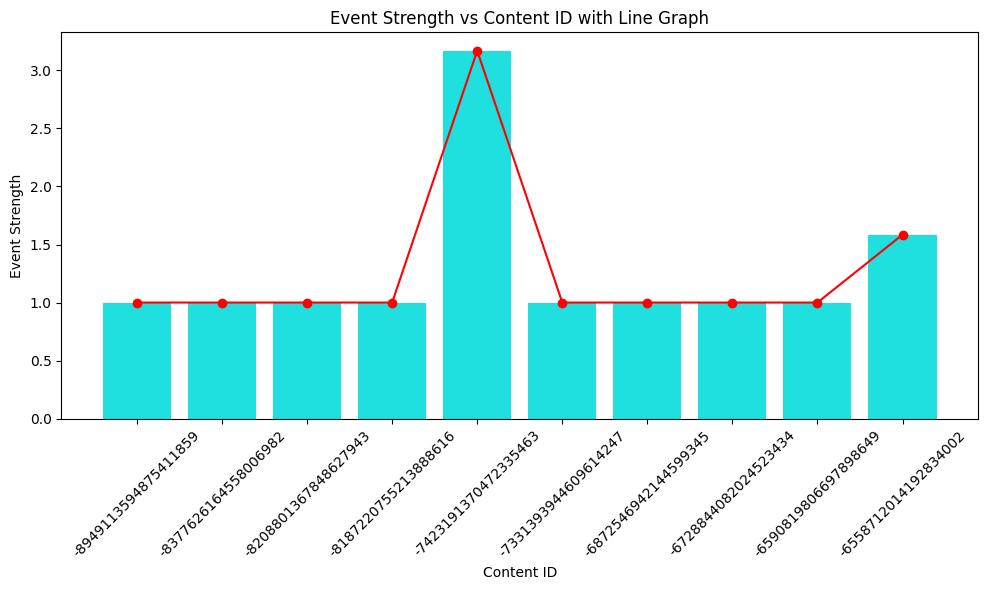

In [ ]:

dff = interactions_full_df.head(10)
dff['contentId'] = dff['contentId'].astype(str)

# Plotting
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x='contentId', y='eventStrength', data=dff, color='aqua')

# Add a trend line (here, we use a simple linear regression line)
plt.plot(dff['contentId'], dff['eventStrength'], marker='o', linestyle='-', color='r')

# Set labels and title
plt.xlabel('Content ID')
plt.ylabel('Event Strength')
plt.title('Event Strength vs Content ID with Line Graph')

# Rotate x-axis labels for better readability (since the contentId values might be large)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


##Step 5: Evaluation: Splitting the data and using evaluation Metrics

Evaluation is a critical step in machine learning projects, since it allows comparing different algorithms and hyperparameter choices for models in an objective manner.
One important part of evaluation is to make sure that the trained model generalizes to data it was not trained on by using **Cross-validation** techniques. We use here a simple cross-validation approach named **holdout**, where a random sample of the data (20% in this case) are held out from the training process and only used for evaluation. All metrics reported here are computed over the **test set**.

One will want a more robust way to split train and test sets: by a reference date, where the train set contains all interactions before that date and the test set contains interactions after that date. For simplicity we will use the first random approach for this notebook but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

In [ ]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'],
                                   test_size=0.20,
                                   random_state=42)

print('Total number of interactions on Train set: %d' % len(interactions_train_df))
print('Total number of interactions on Test set: %d' % len(interactions_test_df))

Total number of interactions on Train set: 31284
Total number of interactions on Test set: 7822


In Recommender Systems, there is a pretty large set of widely adopted metrics for evaluation. We have chosen to work with the Top-N accuracy metrics, which evaluate how good the accuracy of top recommendations provided to a user is when compared to items the user has actually interacted with in a test set.
The way the evaluation method works is as follows:
For each user
For each item the user has interacted with in a test set
Sample 100 other items the user has never interacted with.
Ps. Here we naively assume those non interacted items are not relevant to the user, which may not be the case, as the user may just not be aware of those not interacted items. But let's hold this assumption.
Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted ("non-relevant!) items
Calculate the Top-N accuracy values for this user and interacted item from the ranked list of recommendations
Calculate the overall Top-N accuracy values.

##**Using Top-N accuracy metric**

Top-N accuracy metric chosen was Recall@N, which measures whether the interacted item is within the top N items (hit) in the ranked list of 101 recommendations for a user.

In [ ]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [ ]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [ ]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])
        interacted_items_count_testset = len(person_interacted_items_testset)

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id,
                                               items_to_ignore=get_items_interacted(person_id,
                                                                                    interactions_train_indexed_df),
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id,
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items,
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())

        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
        return global_metrics, detailed_results_df

model_evaluator = ModelEvaluator()

In [ ]:
#Defining the plot function
def chart(metric, modelName):
  # Data for the bar plot
  data = metric

  # Extract the keys and values for plotting
  labels = ['recall@5', 'recall@10']
  values = [data['recall@5'], data['recall@10']]

  # Create a bar plot
  plt.figure(figsize=(8, 6))
  bars = plt.bar(labels, values, color=['#FFB3BA', '#FFDFBA'])

  # Add values above each bar
  for bar in bars:
      yval = bar.get_height()  # Get the height of the bar (the value)
      plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=8)

  # Add labels and title
  plt.ylabel('Recall Score')
  plt.title(f"Evaluation: Recall Scores for Model: {data['modelName']}")

  # Show the plot
  plt.tight_layout()
  plt.show()

##Step 6: Popularity model

One of the more common, and usually hard to beat, baseline approaches is the Popularity model. Actually, this model is not personalized – it just recommends to a user the most popular items that the user has never consumed before. Since the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.

The whole point of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

In [ ]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


<ipython-input-19-29c44d5c427a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['contentId'] = dff['contentId'].astype(str)


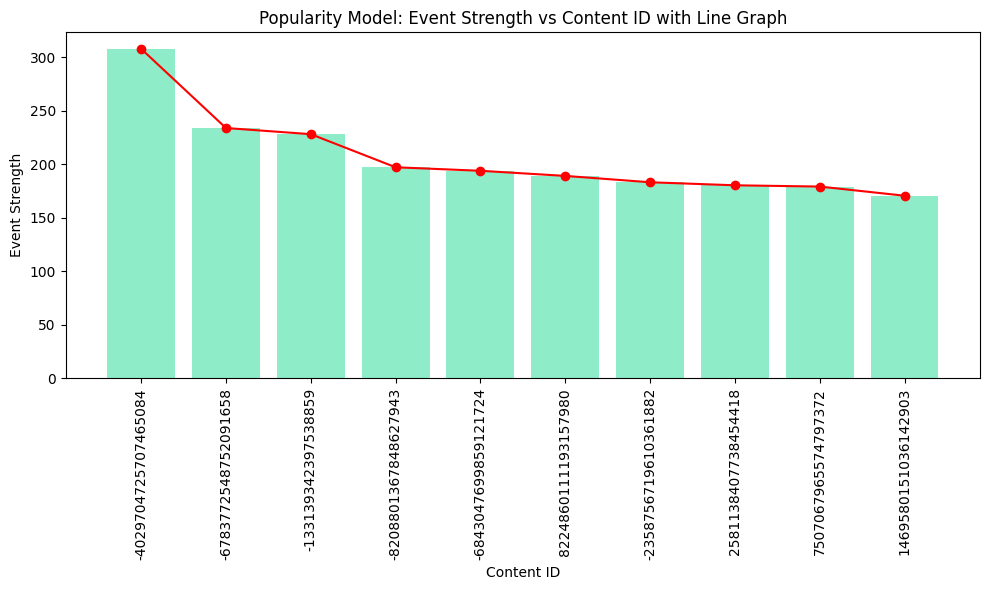

In [ ]:
# To plot the popularity model
dff = item_popularity_df.head(10)
dff['contentId'] = dff['contentId'].astype(str)

# Plotting
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x='contentId', y='eventStrength', data=dff, color='mediumspringgreen',alpha=0.5)

# Add a trend line (here, we use a simple linear regression line)
plt.plot(dff['contentId'], dff['eventStrength'], marker='o', linestyle='-', color='r')

# Set labels and title
plt.xlabel('Content ID')
plt.ylabel('Event Strength')
plt.title('Popularity Model: Event Strength vs Content ID with Line Graph')

# Rotate x-axis labels for better readability (since the contentId values might be large)
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
articles_df = pd.read_csv('shared_articles.csv')  # Or your articles CSV path
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']


In [ ]:
class PopularityRecommender:

    MODEL_NAME = 'Popularity'

    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'contentId',
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

popularity_model = PopularityRecommender(item_popularity_df, articles_df)

Here we perform the evaluation of the Popularity model, using the above described method.
It achieved the **Recall@5** of **0.2417**, meaning that about **24%** of items that have been interacted with in the test set were ranked by Popularity model among the top-5 items (from lists with 100 random items). And **Recall@10** was even higher (**37%**), as expected.

In [ ]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)


Evaluating Popularity recommendation model...


<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


1139 users processed


In [ ]:
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)


Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2418818716440808, 'recall@10': 0.3725389925850166}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,28,50,192,0.145833,0.260417,3609194402293569455
17,12,25,134,0.089552,0.186567,-2626634673110551643
16,13,23,130,0.100000,0.176923,-1032019229384696495
10,5,9,117,0.042735,0.076923,-1443636648652872475
82,26,40,88,0.295455,0.454545,-2979881261169775358
161,12,18,80,0.150000,0.225000,-3596626804281480007
65,20,34,73,0.273973,0.465753,1116121227607581999
81,17,23,69,0.246377,0.333333,692689608292948411
106,14,18,69,0.202899,0.260870,-9016528795238256703
52,21,28,68,0.308824,0.411765,3636910968448833585


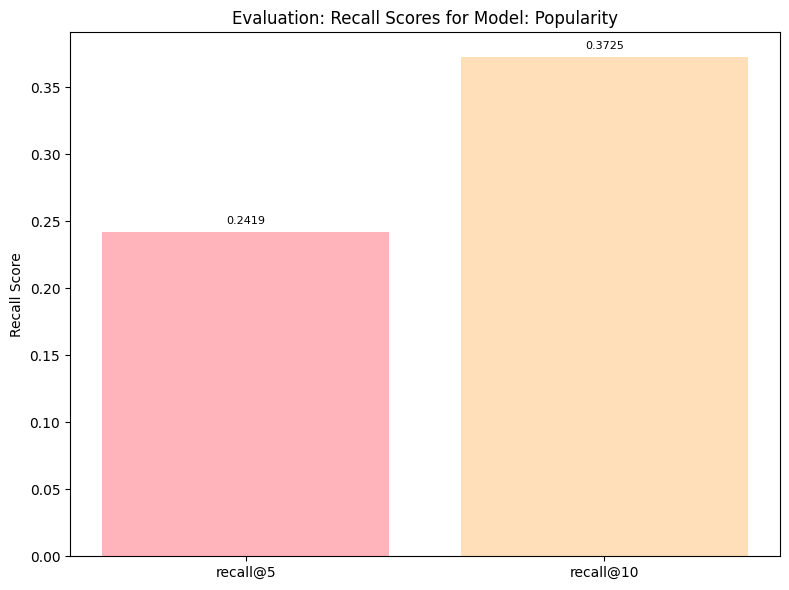

In [ ]:
chart(pop_global_metrics, 'Popularity')

##Step 7: Content-Based Filtering model (Using TFID, cosine, BERT model and Wordnet)

Content-based filtering methods use the description or attributes of items, which the user has rated or interacted with, in order to recommend similar items. It solely relies on the choices the user has made previously and is, therefore, much more resilient in the face of cold-start problems. For textual items—articles, news, or books—using raw text to create profiles of the items and users is actually quite simple.
Here, we will use a very popular technique in information retrieval—search engines—named TF-IDF. This technique converts unstructured text into a vector structure where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. Since all items will be represented in the same Vector Space Model, it is easy to compute similarity between articles.

In [ ]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638118 stored elements in Compressed Sparse Row format>

In [ ]:
print(tfidf_matrix)

  (0, 1605)	0.6984475181887172
  (0, 4824)	0.0501803272347791
  (0, 1132)	0.09151074125290892
  (0, 1505)	0.03863261190161514
  (0, 4610)	0.041009675559322535
  (0, 528)	0.36838520611442205
  (0, 4940)	0.01980299222680421
  (0, 4325)	0.03322794435893947
  (0, 1430)	0.014650670068461161
  (0, 1847)	0.01924139277999696
  (0, 1932)	0.013454048216517678
  (0, 3624)	0.03199891117355705
  (0, 4806)	0.028344970841210643
  (0, 4208)	0.05948691431030664
  (0, 3741)	0.04550228392055388
  (0, 3799)	0.05325965627850692
  (0, 4415)	0.13175911270079005
  (0, 1078)	0.03144356568621534
  (0, 1725)	0.03581865287829598
  (0, 4469)	0.016621030187682947
  (0, 2561)	0.0211177020525167
  (0, 3533)	0.04416374977438685
  (0, 2741)	0.05882790040743304
  (0, 3970)	0.040116971082651255
  (0, 4020)	0.01621942103277125
  :	:
  (3045, 2551)	0.04379656517720175
  (3046, 4976)	0.231656783998254
  (3046, 613)	0.07545310682213181
  (3046, 4677)	0.06812738278369762
  (3046, 3567)	0.10662644807409383
  (3046, 3314)	0.089

To model the user profile, we average all the item profiles the user has interacted with. The average is weighted by the interaction strength; in other words, items that the user has strongly interacted with (for example, liked or commented) will have a higher weight in the final user profile.

In [ ]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])

    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths).toarray(), axis=0) / np.sum(user_item_strengths)
    # Reshape the 1D array to a 2D array with a single row
    user_item_strengths_weighted_avg = user_item_strengths_weighted_avg.reshape(1, -1) # Reshape to 2D
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles():
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [ ]:

user_profiles = build_users_profiles()
len(user_profiles)

1140

Now, take a look at the profile, which is a unit vector of 5000 length. The value in each position represents how relevant is a token (unigram or bigram) for that particular profile.

Looking at the profile, it would seem that the top relevant tokens represent the professional interests in machine learning, deep learning, artificial intelligence, and the Google Cloud Platform.

In [ ]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
df3= pd.DataFrame(sorted(zip(tfidf_feature_names,
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])
df3

(1, 5000)


,token,relevance
0,learning,0.298835
1,machine learning,0.246087
2,machine,0.237933
3,google,0.203117
4,data,0.169849
5,ai,0.156280
6,algorithms,0.115706
7,like,0.097790
8,language,0.087673
9,people,0.082061


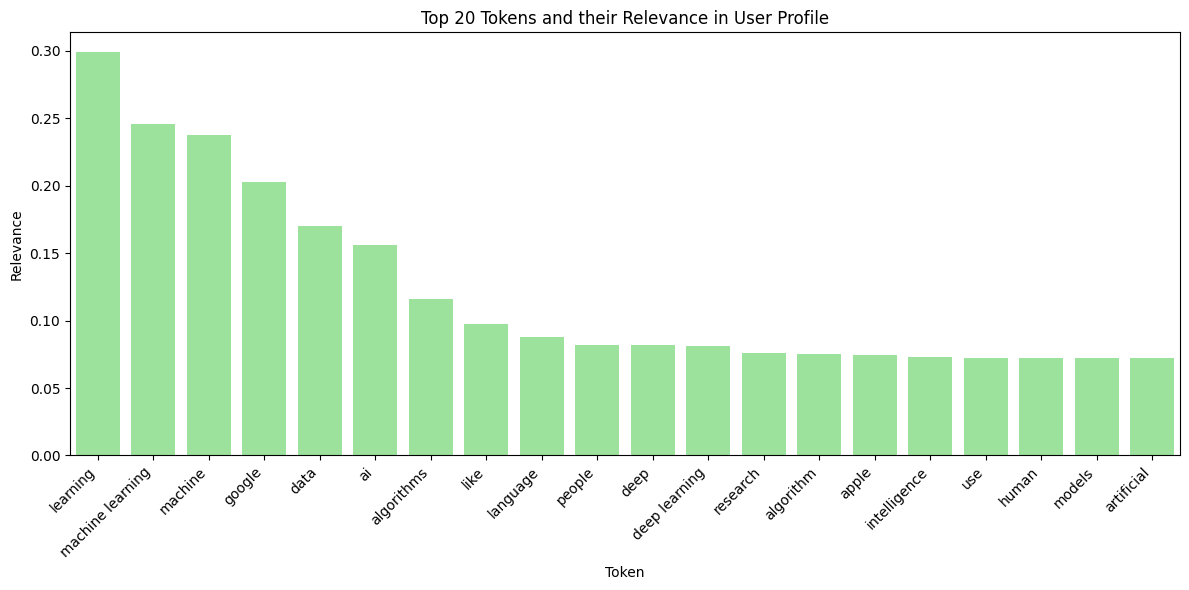

In [ ]:
# Plotting the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x='token', y='relevance', data=df3, color='lightgreen')
plt.xlabel('Token')
plt.ylabel('Relevance')
plt.title('Top 20 Tokens and their Relevance in User Profile')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
class ContentBasedRecommender:

    MODEL_NAME = 'Content-Based'

    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))

        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'contentId',
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

content_based_recommender_model = ContentBasedRecommender(articles_df)

With personalized recommendation— content-based filtering model—we reach a **Recall@5** of approximately **0.162**, meaning about **16%** of the interacted items from the test set were ranked by this model among the top-5 items from lists with 100 random items.
And **Recall@10** was **0.261 (52%)**.
The lower performance of the Content-Based model compared to the Popularity model may indicate that users are not that fixed in content very similar to what they have read before.

In [ ]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)


Evaluating Content-Based Filtering model...


<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set depr

1139 users processed


<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set depr

In [ ]:
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)


Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.16338532344668882, 'recall@10': 0.26118639734083354}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,15,24,192,0.078125,0.125000,3609194402293569455
17,18,29,134,0.134328,0.216418,-2626634673110551643
16,20,33,130,0.153846,0.253846,-1032019229384696495
10,32,46,117,0.273504,0.393162,-1443636648652872475
82,6,15,88,0.068182,0.170455,-2979881261169775358
161,11,23,80,0.137500,0.287500,-3596626804281480007
65,8,13,73,0.109589,0.178082,1116121227607581999
81,8,19,69,0.115942,0.275362,692689608292948411
106,3,9,69,0.043478,0.130435,-9016528795238256703
52,3,8,68,0.044118,0.117647,3636910968448833585


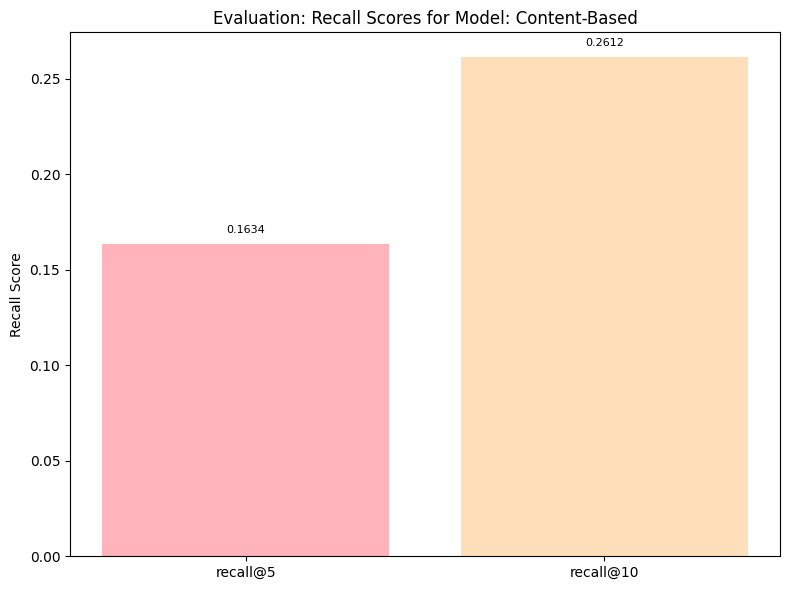

In [ ]:
chart(cb_global_metrics, 'Content-Based: TFID, Cosine Similarity')

In [ ]:
# Initialize BERT Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a piece of text
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Convert to numpy array

# Function to get WordNet synonyms for a word
def get_wordnet_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

# Function to enhance word-level similarity using WordNet
def enhance_with_wordnet(text):
    words = text.split()
    enhanced_text = []
    for word in words:
        synonyms = get_wordnet_synonyms(word)
        if synonyms:
            enhanced_text.extend(synonyms)  # Add synonyms to the list
        else:
            enhanced_text.append(word)
    return ' '.join(enhanced_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Apply WordNet to the 'title' column
articles_df['enhanced_title'] = articles_df['title'].apply(enhance_with_wordnet)
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,enhanced_title
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,"Ethereum, angstrom_unit adenine antiophthalmic..."
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,Bitcoin Future: When GBPcoin of Branson gain_g...
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,google Google data datum data_point informatio...
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,IBM require wish wishing want deficiency priva...
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,IEEE to lecture public_lecture babble_out spea...


In [ ]:
# Applying BERT embeddings to enhanced article titles
article_embeddings = []
for title in articles_df['title']:
    enhanced_title = enhance_with_wordnet(title)  # Enhance title with WordNet synonyms
    embedding = get_bert_embeddings(enhanced_title)  # Get BERT embeddings for enhanced title
    article_embeddings.append(embedding)

# Convert list of embeddings into a numpy array
article_embeddings = np.array(article_embeddings)

# Normalizing the BERT embeddings
article_embeddings_norm = article_embeddings / np.linalg.norm(article_embeddings, axis=1, keepdims=True)  # Normalize

# Save embeddings to a file
with open('article_embeddings.pkl', 'wb') as f:
    pickle.dump(article_embeddings_norm, f)

In [ ]:
def find_most_similar_articles(article_index, top_n=5):
    # Calculate cosine similarity between the target article and all other articles
    similarities = cosine_similarity(article_embeddings_norm[article_index].reshape(1, -1), article_embeddings_norm)

    # Get the indices of the most similar articles (excluding itself)
    most_similar_indices = np.argsort(similarities[0])[::-1][1:top_n+1]  # Exclude itself

    # Return the indices and their similarity scores
    return most_similar_indices, similarities[0][most_similar_indices]

# Example: Find the 5 most similar articles to the article at index 0
article_index = 0  # Replace with the desired article index
most_similar_indices, similarity_scores = find_most_similar_articles(article_index)

print(f"The {len(most_similar_indices)} most similar articles to article at index {article_index}:")
for i, index in enumerate(most_similar_indices):
    print(f"{i+1}. Article index: {index}, Similarity score: {similarity_scores[i]}")
    # Access the article title using articles_df.iloc[index]['title']
    print(articles_df.iloc[index]['title'])


The 5 most similar articles to article at index 0:
1. Article index: 87, Similarity score: 0.9474073052406311
Com HoloLens, Microsoft torna realidade a mensagem holográfica de "Star Wars"
2. Article index: 63, Similarity score: 0.942146897315979
Acquia's Dev Desktop - a Drupal server for beginners
3. Article index: 1761, Similarity score: 0.9386967420578003
Walmart começa a recusar cartões de crédito Visa no Canadá | EXAME.com
4. Article index: 1550, Similarity score: 0.9385210275650024
A Baseline for Hybrid Mobile Developers
5. Article index: 2315, Similarity score: 0.9380126595497131
Are you a bitcoin denialist? - Chris Skinner's blog


In [ ]:
# Create a list to store the results
results = []

# Create a list to store the results
results = []

for i, index in enumerate(most_similar_indices):

    results.append({'Rank': i + 1,
            'Article Index': index,
            'Similarity Score': similarity_scores[i],
            'Article Title': articles_df.iloc[index]['title']})

# Create a DataFrame from the results list
df_results = pd.DataFrame(results)

# Print the DataFrame
print(df_results)


   Rank  Article Index  Similarity Score  \
0     1             87          0.947407   
1     2             63          0.942147   
2     3           1761          0.938697   
3     4           1550          0.938521   
4     5           2315          0.938013   

                                       Article Title  
0  Com HoloLens, Microsoft torna realidade a mens...  
1  Acquia's Dev Desktop - a Drupal server for beg...  
2  Walmart começa a recusar cartões de crédito Vi...  
3            A Baseline for Hybrid Mobile Developers  
4  Are you a bitcoin denialist? - Chris Skinner's...  


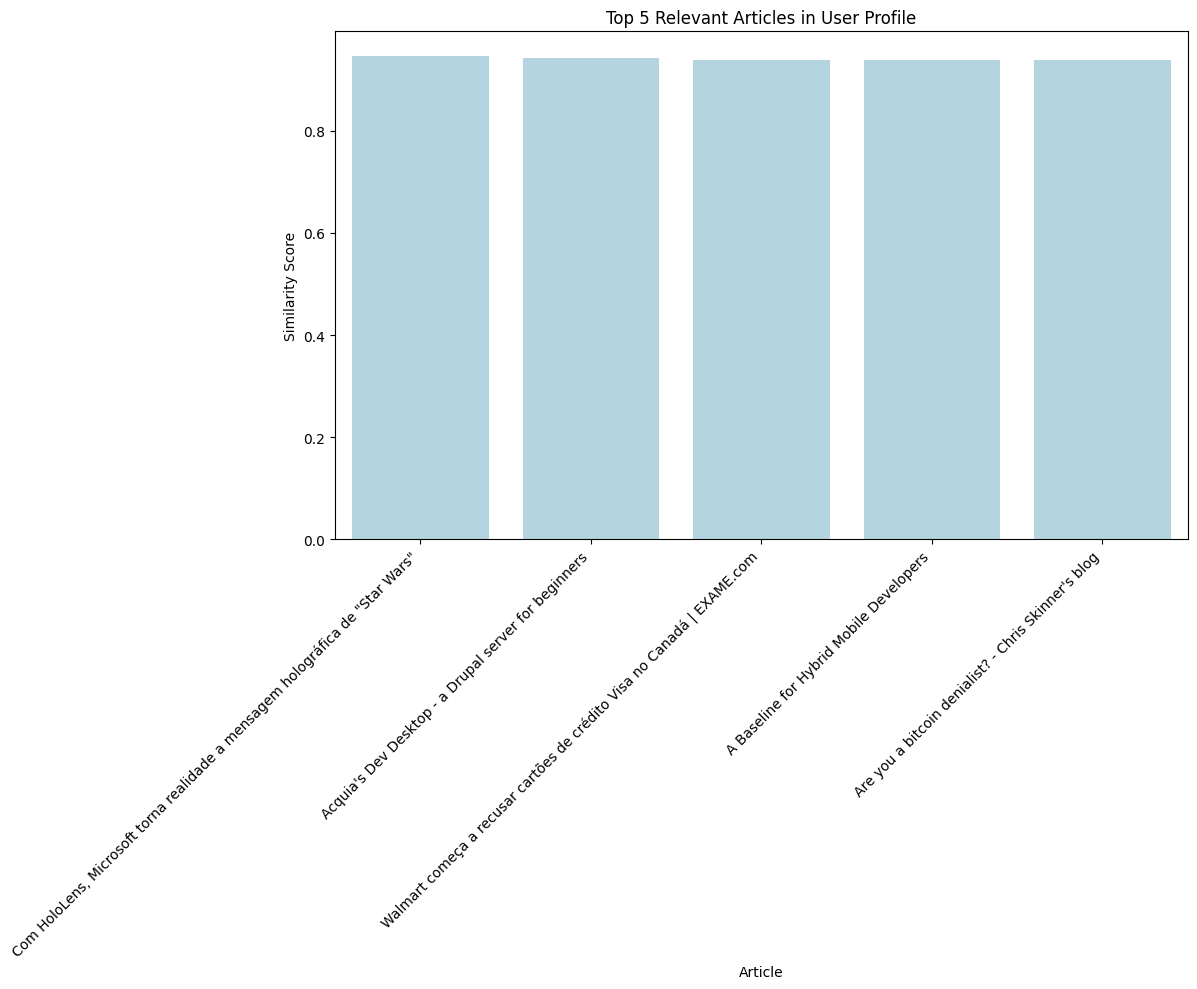

In [ ]:
# Plotting the bar graph
plt.figure(figsize=(12, 10))
sns.barplot(x='Article Title', y='Similarity Score', data=df_results, color='lightblue')

plt.xlabel('Article')
plt.ylabel('Similarity Score')
plt.title('Top 5 Relevant Articles in User Profile')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
class BertWordNetRecommender:
    def __init__(self, item_embeddings, item_ids):
        with open('article_embeddings.pkl', 'rb') as f:
            self.item_embeddings = pickle.load(f)
        self.item_ids = item_ids

    def get_model_name(self):
        return "BERT WordNet Recommender"

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get interacted items for the user
        interacted_items = get_items_interacted(user_id, interactions_full_indexed_df)

        # Get embeddings for interacted items
        interacted_item_indices = [self.item_ids.index(item_id) for item_id in interacted_items if item_id in self.item_ids]
        if not interacted_item_indices:  # Handle case where no interacted items are found
            return pd.DataFrame({'contentId': []})

        user_profile = self.item_embeddings[interacted_item_indices].mean(axis=0)  # Average embeddings

        # Calculate cosine similarity between user profile and all item embeddings
        cosine_similarities = cosine_similarity(user_profile.reshape(1, -1), self.item_embeddings)

        # Get indices of top-N similar items
        top_n_indices = cosine_similarities.argsort()[0][-topn:][::-1]

        # Get recommended item IDs
        recommended_item_ids = [self.item_ids[idx] for idx in top_n_indices]

        # Filter out ignored items
        recommended_item_ids = [item_id for item_id in recommended_item_ids if item_id not in items_to_ignore]

        # Return recommendations
        recommendations_df = pd.DataFrame({'contentId': recommended_item_ids})

        return recommendations_df

# Create the BERT WordNet Recommender instance
bert_wordnet_recommender = BertWordNetRecommender(article_embeddings_norm, articles_df['contentId'].tolist())

In [ ]:
# Evaluate the model
print('Evaluating BERT WordNet recommendation model...')
bert_wn_global_metrics, bert_wn_detailed_results_df = model_evaluator.evaluate_model(bert_wordnet_recommender)


Evaluating BERT WordNet recommendation model...


<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set depr

1139 users processed


In [ ]:
print('\nGlobal metrics for BERT WordNet model:\n', bert_wn_global_metrics)
bert_wn_detailed_results_df.head(10)


Global metrics for BERT WordNet model:
 {'modelName': 'BERT WordNet Recommender', 'recall@5': 0.08015852723088725, 'recall@10': 0.14472002045512655}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,11,23,192,0.057292,0.119792,3609194402293569455
17,6,18,134,0.044776,0.134328,-2626634673110551643
16,11,23,130,0.084615,0.176923,-1032019229384696495
10,11,23,117,0.094017,0.196581,-1443636648652872475
82,6,8,88,0.068182,0.090909,-2979881261169775358
161,2,8,80,0.025000,0.100000,-3596626804281480007
65,8,11,73,0.109589,0.150685,1116121227607581999
81,5,10,69,0.072464,0.144928,692689608292948411
106,3,7,69,0.043478,0.101449,-9016528795238256703
52,4,6,68,0.058824,0.088235,3636910968448833585


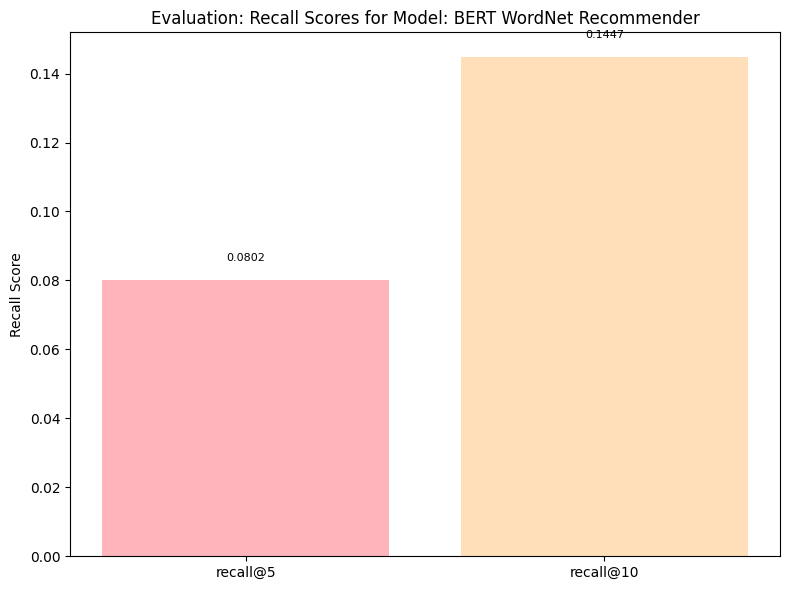

In [ ]:
chart(bert_wn_global_metrics, 'BERT WordNet')

In [ ]:
#To compare the score of cb_global_metrics and bert_wn_global_metrics

print("Content-Based Filtering Model Metrics:")
print(cb_global_metrics)
print("\nBERT WordNet Model Metrics:")
print(bert_wn_global_metrics)


Content-Based Filtering Model Metrics:
{'modelName': 'Content-Based', 'recall@5': 0.16338532344668882, 'recall@10': 0.26118639734083354}

BERT WordNet Model Metrics:
{'modelName': 'BERT WordNet Recommender', 'recall@5': 0.08015852723088725, 'recall@10': 0.14472002045512655}


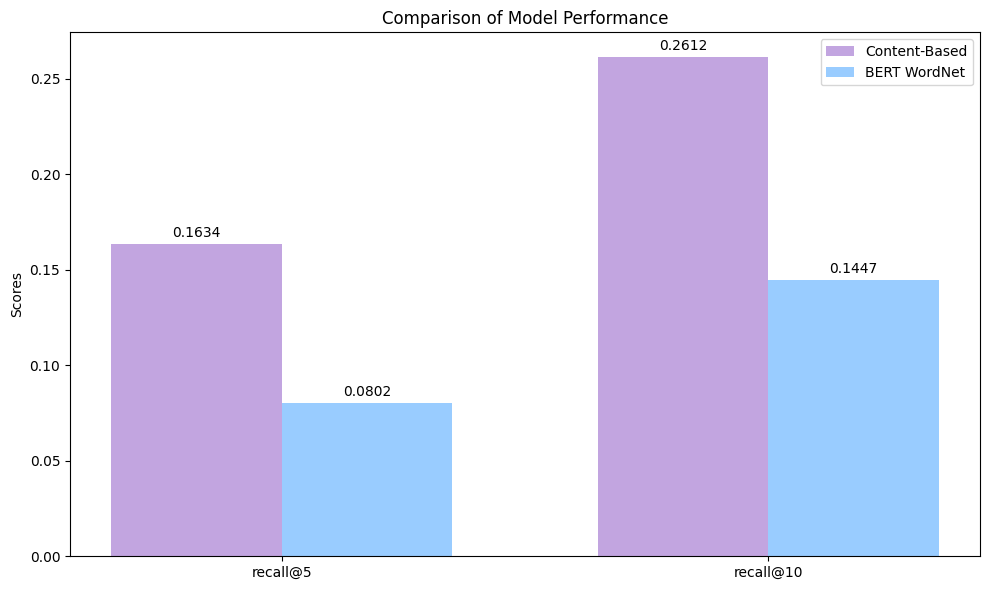


Recall@5 - Content-Based TFID: 0.1634, BERT WordNet: 0.0802
Content-Based TFID Filtering model has a higher Recall@5.

Recall@10 - Content-Based TFID: 0.2612, BERT WordNet: 0.1447
Content-Based TFID Filtering model has a higher Recall@10.


In [ ]:
# Comparison

metrics_to_compare = ['recall@5', 'recall@10']  # Add more if needed

cb_values = [cb_global_metrics[metric] for metric in metrics_to_compare]
bert_wn_values = [bert_wn_global_metrics[metric] for metric in metrics_to_compare]


x = range(len(metrics_to_compare))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, cb_values, width, label='Content-Based', color ='#c2a5e0')
rects2 = ax.bar([i + width for i in x], bert_wn_values, width, label='BERT WordNet', color ='#99ccff')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(metrics_to_compare)
ax.legend()

# Add labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Comparing Recall@5
cb_recall_at_5 = cb_global_metrics['recall@5']
bert_wn_recall_at_5 = bert_wn_global_metrics['recall@5']

print(f"\nRecall@5 - Content-Based TFID: {cb_recall_at_5:.4f}, BERT WordNet: {bert_wn_recall_at_5:.4f}")
if cb_recall_at_5 > bert_wn_recall_at_5:
    print("Content-Based TFID Filtering model has a higher Recall@5.")
elif bert_wn_recall_at_5 > cb_recall_at_5:
    print("BERT WordNet model has a higher Recall@5.")
else:
    print("Both models have the same Recall@5.")

# Comparing other metrics (example: Recall@10)
cb_recall_at_10 = cb_global_metrics['recall@10']
bert_wn_recall_at_10 = bert_wn_global_metrics['recall@10']

print(f"\nRecall@10 - Content-Based TFID: {cb_recall_at_10:.4f}, BERT WordNet: {bert_wn_recall_at_10:.4f}")
if cb_recall_at_10 > bert_wn_recall_at_10:
    print("Content-Based TFID Filtering model has a higher Recall@10.")
elif bert_wn_recall_at_10 > cb_recall_at_10:
    print("BERT WordNet model has a higher Recall@10.")
else:
    print("Both models have the same Recall@10.")


# Collaborative Filtering model

Collaborative Filtering (CF) has two main implementation strategies:  
- **Memory-based**: The implemented approaches of Collaborative Filtering—memory-based and model-based: The former makes use of the memory of past user interactions, whether in computing user similarity based on items interacted with (user-based approach) or in computing the similarities of items based on users who have interacted with them (item-based approach).
A typical example of this type of approach is User Neighbourhood-based CF, where the top-N most similar users—often computed using Pearson correlation—are identified for a user, and then used to recommend items those similar users liked, but that the current user has never seen before. This method is relatively trivial to implement but doesn't scale terribly well for many users.

- **Model-based**: In this approach, models are induced through machine-learning algorithms with the objective of recommending items to users. The exist many model-based CF algorithms, including neural networks, Bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SVD) and probabilistic latent semantic analysis.


## Matrix Factorization

Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One of the advantages of using this approach is that instead of having a high-dimensional matrix with an abundant number of missing values, we are going to deal with a much smaller matrix in a lower dimensional space.
A reduced presentation could be used for either user-based or item-based neighborhood algorithms that are presented in the previous section. There is the benefit of this paradigm. It handles the sparsity of the original matrix better than memory-based ones. Also, the comparison of similarities on the resulting matrix is much more scalable, especially for large sparse datasets.

We have used a popular latent factor model called Singular Value Decomposition (SVD).

One of the most important choices is how many factors to use in the factorization of the user-item matrix. The larger the number of factors, the more accurate the factorization becomes in the original matrix reconstructions. Thus, enabling the model to learn too many details about the original matrix would cause bad generalization over data that it was not trained on. Decreasing the number of factors makes the model generalize better.

In [ ]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId',
                                                          columns='contentId',
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [ ]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1140x2926 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

In [ ]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [ ]:
U.shape

(1140, 15)

In [ ]:
Vt.shape

(15, 2926)

In [ ]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse anymore. It was generated predictions for items the user have not yet interaction, which will be exploited for the recommendations part.


In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_ratings

array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [-0.02995379,  0.00805715, -0.01846307, ..., -0.01083078,
        -0.00118591,  0.0096798 ],
       [-0.01845505,  0.00467019,  0.01219602, ...,  0.00409507,
         0.00019482, -0.00752562],
       [-0.01506374,  0.00327732,  0.13391269, ..., -0.01191815,
         0.06422074,  0.01303244]])

In [ ]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.139129,0.137930,0.136531,0.143948,0.136815,0.137339,0.137508,0.143534,0.136428,0.135681,...,0.137351,0.127822,0.137946,0.139653,0.140324,0.136888,0.135787,0.134560,0.135862,0.136246
-9216926795620865886,0.138044,0.137916,0.138698,0.137878,0.137969,0.137990,0.137974,0.138049,0.138217,0.138151,...,0.137962,0.139527,0.138009,0.138117,0.139634,0.138058,0.138222,0.138864,0.138480,0.138323
-9194572880052200111,0.135998,0.137652,0.137283,0.137536,0.140363,0.137807,0.141246,0.136284,0.135301,0.138512,...,0.139257,0.143161,0.139139,0.140077,0.154976,0.140109,0.140654,0.135861,0.139332,0.153114
-9192549002213406534,0.141924,0.137996,0.134663,0.137080,0.139946,0.138574,0.139473,0.144469,0.143333,0.138428,...,0.140233,0.167426,0.138849,0.137037,0.141820,0.139260,0.139513,0.136804,0.140862,0.148793
-9190737901804729417,0.140209,0.137408,0.138708,0.138672,0.137725,0.138218,0.138390,0.138418,0.134883,0.140193,...,0.138373,0.138459,0.138169,0.137990,0.134041,0.137820,0.138100,0.138286,0.138630,0.136178
-9189659052158407108,0.138932,0.138699,0.138117,0.137621,0.138920,0.137766,0.138568,0.138200,0.140572,0.140365,...,0.140725,0.148152,0.137645,0.138165,0.149152,0.138912,0.139595,0.139807,0.140419,0.145698
-9176143510534135851,0.143208,0.138673,0.139514,0.139114,0.137664,0.137447,0.139833,0.140564,0.144698,0.144440,...,0.138367,0.146220,0.136204,0.138087,0.137317,0.137917,0.138546,0.142601,0.141431,0.142154
-9172673334835262304,0.138527,0.138021,0.138274,0.137827,0.137997,0.138037,0.138104,0.138259,0.137633,0.138397,...,0.138588,0.140146,0.138013,0.137839,0.137033,0.137969,0.138337,0.138361,0.138813,0.137538
-9171475473795142532,0.140720,0.137865,0.138061,0.137633,0.138231,0.138089,0.139009,0.137552,0.137143,0.140581,...,0.139046,0.139895,0.138000,0.137958,0.136061,0.138183,0.138817,0.138060,0.139205,0.137198


In [ ]:
len(cf_preds_df.columns)

1140

In [ ]:
class CFRecommender:

    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'contentId',
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

##Evaluating the Collaborative Filtering model:
We obtained the following
Recall@5 (33%) and
Recall@10 (46%)
These values are way higher than both the Popularity model and Content-Based model.

In [ ]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)


Evaluating Collaborative Filtering (SVD Matrix Factorization) model...


<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set depr

1139 users processed


In [ ]:
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)


Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.33392994119151115, 'recall@10': 0.46803886474047557}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,21,46,192,0.109375,0.239583,3609194402293569455
17,30,56,134,0.223881,0.417910,-2626634673110551643
16,16,34,130,0.123077,0.261538,-1032019229384696495
10,38,51,117,0.324786,0.435897,-1443636648652872475
82,39,48,88,0.443182,0.545455,-2979881261169775358
161,22,34,80,0.275000,0.425000,-3596626804281480007
65,24,32,73,0.328767,0.438356,1116121227607581999
81,16,21,69,0.231884,0.304348,692689608292948411
106,20,28,69,0.289855,0.405797,-9016528795238256703
52,23,30,68,0.338235,0.441176,3636910968448833585


<ipython-input-80-a1ff78543880>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_df1['_person_id'] = interactions_df1['_person_id'].astype(str)


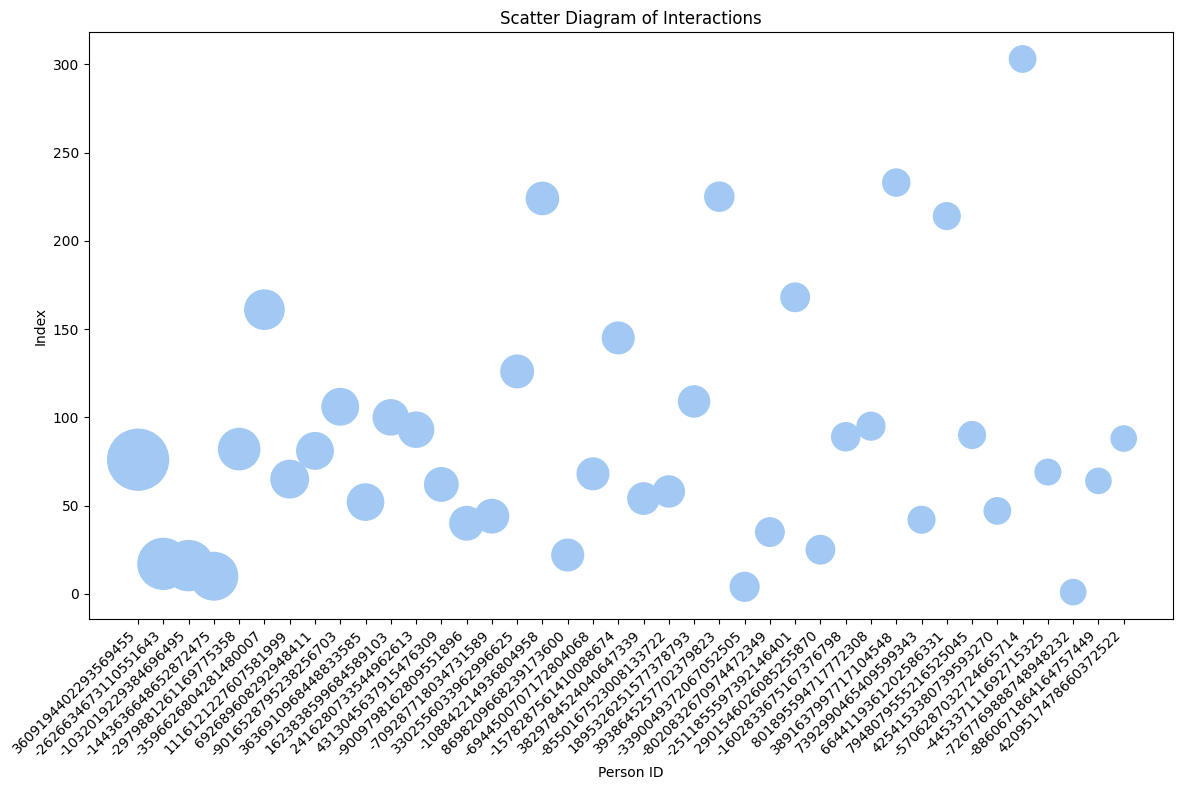

In [ ]:
# Plotting a scatter diagram for above dataframe with person_id on x axis and index on y axis. The radius of the dots should be proportional to the interacted counts.

def visualize_interactions(interactions_df1):

    interactions_df1= cf_detailed_results_df.head(40)

    interactions_df1['_person_id'] = interactions_df1['_person_id'].astype(str)
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    plt.scatter(interactions_df1['_person_id'], interactions_df1.index, s=interactions_df1['interacted_count'] * 10)  # Adjust scaling as needed
    plt.xlabel('Person ID')
    plt.ylabel('Index')
    plt.title('Scatter Diagram of Interactions')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

data = {'person_id': [i for i in range(1,11)],
        'interacted_count': [random.randint(1, 100) for _ in range(10)]}
interactions_df1 = pd.DataFrame(data)

visualize_interactions(interactions_df1)

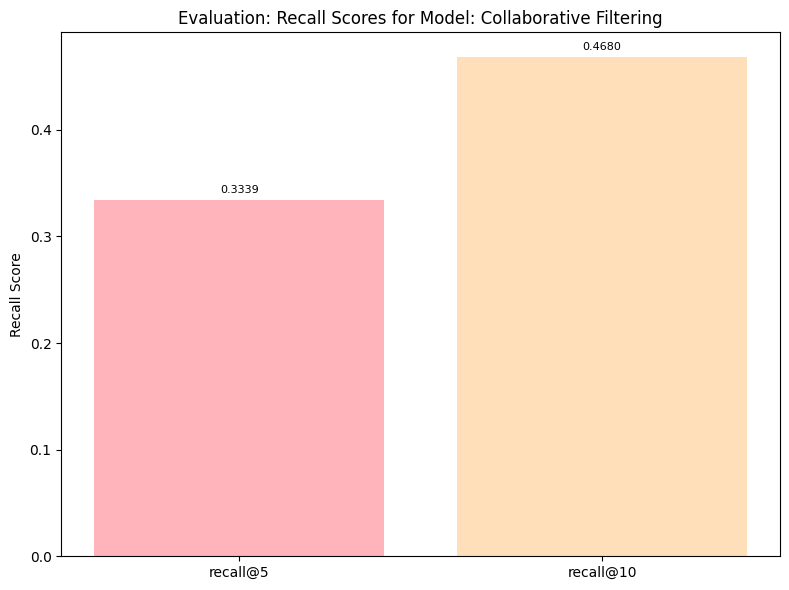

In [ ]:
chart(cf_global_metrics, 'CFRecommender')

## Hybrid Recommender

##Combination of Collaborative Filtering and Content-Based Filtering techniques

Hybrid methods have performed better than individual approaches in many studies and are being increasingly used by both researchers and practitioners.

Implementing the simple hybridization method, which will take a weighted average between the normalized CF scores with the Content-Based scores by ranking with the resulting score. As in this example, given that the CF model is much more precise than the CB model, the weight of the CF and CB models are fixed to 100.0 and 1.0 respectively.

In [ ]:
class HybridRecommender:

    MODEL_NAME = 'Hybrid'

    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})

        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})

        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer',
                                   left_on = 'contentId',
                                   right_on = 'contentId').fillna(0.0)

        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)

        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'contentId',
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

**Hybrid Model results**  
The hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Results show **Recall@5** of **34.2%** and **Recall@10** of **47.9%**

In [ ]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...


<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-16-a102c55f829f>:13: DeprecationWarning: Sampling from a set depr

1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.3430069036052161, 'recall@10': 0.479033495269752}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,22,45,192,0.114583,0.234375,3609194402293569455
17,31,58,134,0.231343,0.432836,-2626634673110551643
16,21,37,130,0.161538,0.284615,-1032019229384696495
10,40,51,117,0.341880,0.435897,-1443636648652872475
82,38,50,88,0.431818,0.568182,-2979881261169775358
161,23,35,80,0.287500,0.437500,-3596626804281480007
65,23,32,73,0.315068,0.438356,1116121227607581999
81,16,21,69,0.231884,0.304348,692689608292948411
106,20,27,69,0.289855,0.391304,-9016528795238256703
52,22,29,68,0.323529,0.426471,3636910968448833585


## Comparing the methods

In [ ]:
global_metrics_df = pd.DataFrame([bert_wn_global_metrics, cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
BERT WordNet Recommender,0.080159,0.144720
Content-Based,0.163385,0.261186
Popularity,0.241882,0.372539
Collaborative Filtering,0.333930,0.468039
Hybrid,0.343007,0.479033


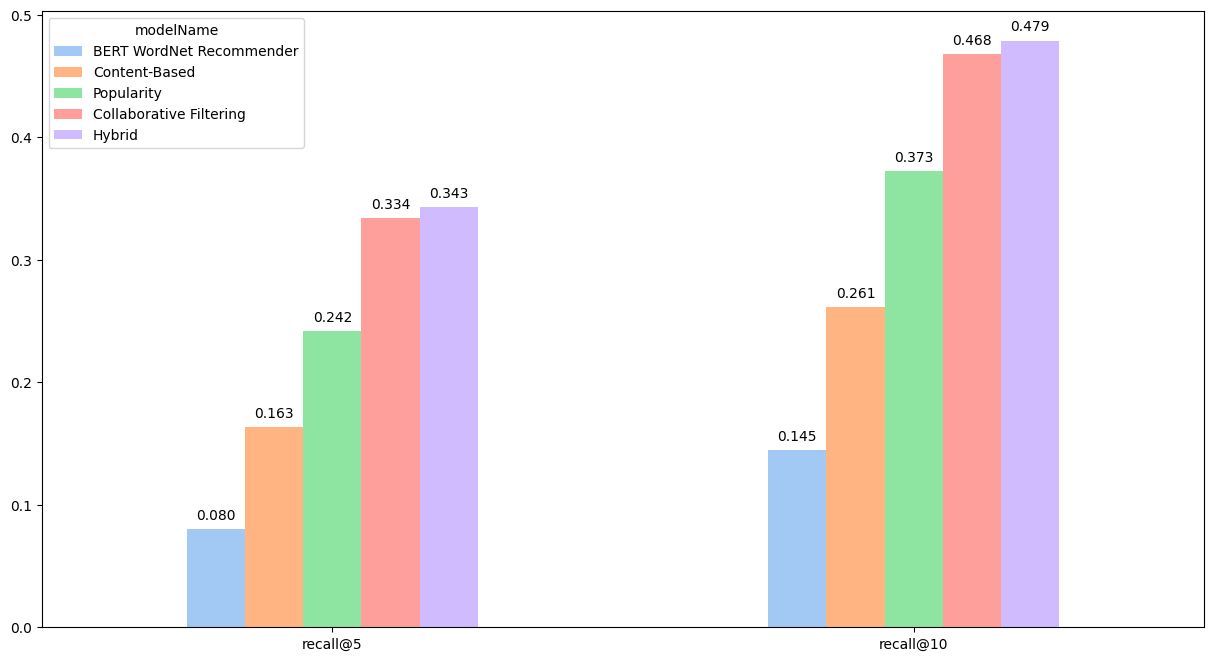

In [ ]:
# Set the seaborn pastel color palette
sns.set_palette("pastel")

# Plot the global metrics as a bar chart with pastel colors
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15, 8))

# Annotate bars with their values
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')

# Set x-axis labels to horizontal
plt.xticks(rotation=0)

# Display the plot in Streamlit
fig=plt.gcf()

So, the performance of the hybrid model is the best out of all.

##**Testing the best model**
**Using Hybrid model for a user.**

In [ ]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left',
                                                      left_on = 'contentId',
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength',
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

##Observing the interactions

In [ ]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
115,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
38,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
8,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
116,3.954196,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
10,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
28,3.700440,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
6,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
113,3.643856,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
42,3.523562,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
43,3.459432,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en


**The recommendations are really good matches.**

In [ ]:
df2 = hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)
df2

,recStrengthHybrid,contentId,title,url,lang
0,25.437103,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
1,25.369932,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
2,24.493428,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
3,24.383245,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
4,24.362064,-6727357771678896471,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...,en
5,24.190477,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
6,24.172447,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,23.932057,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
8,23.865831,-5253644367331262405,"Hello, TensorFlow!",https://www.oreilly.com/learning/hello-tensorflow,en
9,23.811686,1549650080907932816,Spark comparison: AWS vs. GCP,https://www.oreilly.com/ideas/spark-comparison...,en


<ipython-input-73-868bc2a3b691>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


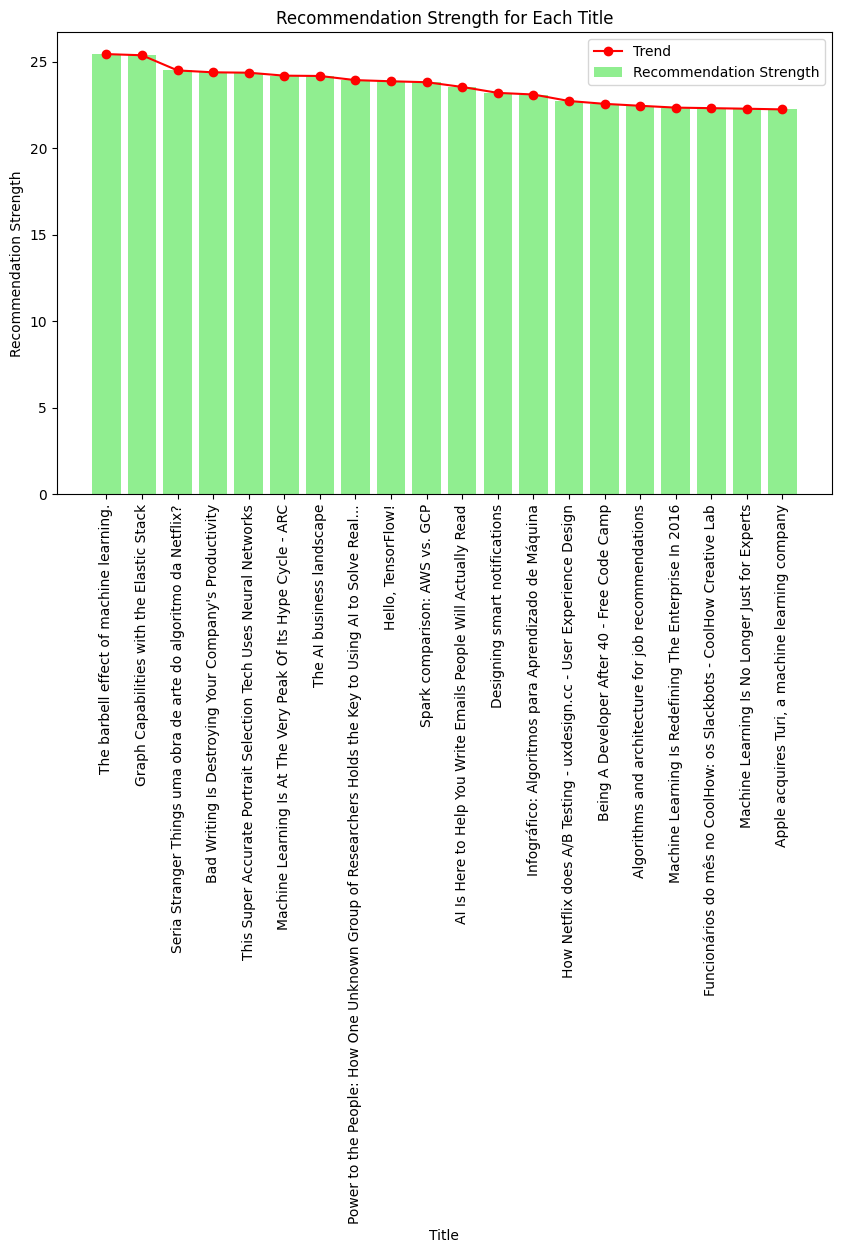

In [ ]:
#To analyse the trend

plt.figure(figsize=(10, 6))

# Create the bar plot
plt.bar(df2['title'], df2['recStrengthHybrid'], color='lightgreen', label='Recommendation Strength')

# Create the line plot overlayed on the bar plot
plt.plot(df2['title'], df2['recStrengthHybrid'], color='red', marker='o', linestyle='-', label='Trend')


plt.xlabel('Title')
plt.ylabel('Recommendation Strength')
plt.title('Recommendation Strength for Each Title')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
final_recomm = df2[['title', 'url']]
final_recomm.head()

,title,url
0,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...
1,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...
2,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...
3,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...
4,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...


In [ ]:

# Use the loaded model
recommendations = hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)
recommendations

,recStrengthHybrid,contentId,title,url,lang
0,25.437103,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
1,25.369932,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
2,24.493428,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
3,24.383245,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
4,24.362064,-6727357771678896471,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...,en
5,24.190477,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
6,24.172447,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,23.932057,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
8,23.865831,-5253644367331262405,"Hello, TensorFlow!",https://www.oreilly.com/learning/hello-tensorflow,en
9,23.811686,1549650080907932816,Spark comparison: AWS vs. GCP,https://www.oreilly.com/ideas/spark-comparison...,en


In [ ]:
response = input("Do you want to send whats app message? y/n")
if response == 'y':
  !python watsapp.py

else:
  response2 = input("Thank you for your response. Do you want to exit? y/n")
  if response2 == 'y': # Enclose y in quotation marks
    print("Good Bye")
  else:
    response3 = input("Do you want to send whats app message? y/n")
    if response3 == 'y': # Enclose y in quotation marks
      !python watsapp.py
    else:
      print("Good Bye")

Do you want to send whats app message? y/nn
Thank you for your response. Do you want to exit? y/ny
Good Bye


# Conclusion

In short, the results show that both content-based filtering and hybrid approaches outperform collaborative filtering used in isolation for article recommendation systems. In content-based filtering, the attributes of articles are used to make a recommendation based on the preferences of a user, while the hybrid approaches use a combination of recommendation strategies in an effort to provide more accurate and personalized suggestions. Collaborative filtering excels at capturing patterns of user behavior but suffers from problems such as data sparsity and cold start problems. These limitations are overcome by the hybrid model, which includes content-based features or combination with collaborative methods, leading to more relevant recommendations; hence, the combination approach appears to be the best strategy for making high-quality article recommendations.